In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score

from collections import Counter

In [3]:
!pip install comet_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.4/586.4 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.2/512.2 kB 51.0 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.6.4
    Uninstalling websocket-client-1.6.4:
      Successfully uninstalled websocket-client-1.6.4
  Attempting uninstall: python-box
    Found existing installation: python-box 7.1.1
    Uninstalling python-box-7.1.1:
      Successfully uninstalled python-box-7.1.1


In [6]:
with open('COMET_API_KEY.txt', 'r') as f:
    key = f.read()
## Create an experiment with your api key
from comet_ml import Experiment
experiment = Experiment(
    api_key=key,
    project_name="baseline-model-test",
    workspace="jingyue",
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/jingyue/baseline-model-test/ed0b2e4869f4425eb4dbea530313c28f



In [10]:
def logreg_fit(X_train, X_val, y_train, y_val):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    predicted_prob = clf.predict_proba(X_val)
    score = clf.score(X_val, y_val)
    return clf, y_pred, predicted_prob[:,1]

In [8]:
df = pd.read_csv('FE1Train.csv')
df

,Unnamed: 0,is_goal,is_emptyNet,season,goal_coordinate,shot_distance_to_goal,angle,goal_rate_dist,goal_rate_angle
0,0,0,0,20162017,-84,84.095184,25.346176,0.001129,0.003745
1,1,0,0,20162017,84,6.082763,-80.537678,0.015604,-0.001179
2,2,0,0,20162017,-84,38.078866,66.801409,0.002493,0.001421
3,3,0,0,20162017,-84,33.615473,30.379126,0.002824,0.003124
4,4,0,0,20162017,-84,38.209946,47.121096,0.002484,0.002014
...,...,...,...,...,...,...,...,...,...
253470,253470,0,0,20182019,84,25.495098,-48.179830,0.003723,-0.001970
253471,253471,0,0,20182019,-84,6.082763,-9.462322,0.015604,-0.010031
253472,253472,0,0,20182019,-84,10.198039,-78.690068,0.009307,-0.001206
253473,253473,0,0,20182019,-84,3.162278,-18.434949,0.030015,-0.005149


In [9]:
# Assuming your DataFrame is named 'df'
X = df[['shot_distance_to_goal','angle']]  # Use double brackets to keep it as a DataFrame
y = df['is_goal']

# Split the data - 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Fit the model
clf_distance, y_pred_distance, predicted_prob_distance = logreg_fit(X_train[['shot_distance_to_goal']], X_val[['shot_distance_to_goal']], y_train, y_val)
clf_angle, y_pred_angle, predicted_prob_angle = logreg_fit(X_train[['angle']], X_val[['angle']], y_train, y_val)
clf_both, y_pred_both, predicted_prob_both = logreg_fit(X_train, X_val, y_train, y_val)

#Random baseline
y_prob_random= np.random.uniform(0,1,y_pred_both.shape)
y_pred_random = np.where(y_prob_random > 0.5, 1, 0)

In [89]:
# Print the columns used for each model
print("Features for Distance model:", X_train[['shot_distance_to_goal']].columns)
print("Features for Both model:", X_train.columns)


Features for Distance model: Index(['shot_distance_to_goal'], dtype='object')
Features for Both model: Index(['shot_distance_to_goal', 'angle'], dtype='object')


In [90]:
print("First few probabilities for Distance model:", predicted_prob_distance[:5])
print("First few probabilities for Both model:", predicted_prob_both[:5])


First few probabilities for Distance model: [0.15792813 0.09743142 0.04747657 0.11400828 0.0743393 ]
First few probabilities for Both model: [0.15853127 0.09942472 0.0485528  0.11196117 0.07502276]


In [13]:
if not os.path.exists('models/'):
    os.mkdir('models/')
pickle.dump(clf_distance, open('models/distance.sav', 'wb'))
pickle.dump(clf_angle, open('models/angle.sav', 'wb'))
pickle.dump(clf_both, open('models/both.sav', 'wb'))

In [14]:
experiment.log_model("distance model", 'models/distance.sav')
experiment.log_model("angle model", 'models/angle.sav')
experiment.log_model("distance and angle model", 'models/both.sav')

{'web': 'https://www.comet.com/api/asset/download?assetId=8a0ea269c84343cc90cad8f4667d2134&experimentKey=ed0b2e4869f4425eb4dbea530313c28f',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=8a0ea269c84343cc90cad8f4667d2134&experimentKey=ed0b2e4869f4425eb4dbea530313c28f',
 'assetId': '8a0ea269c84343cc90cad8f4667d2134'}

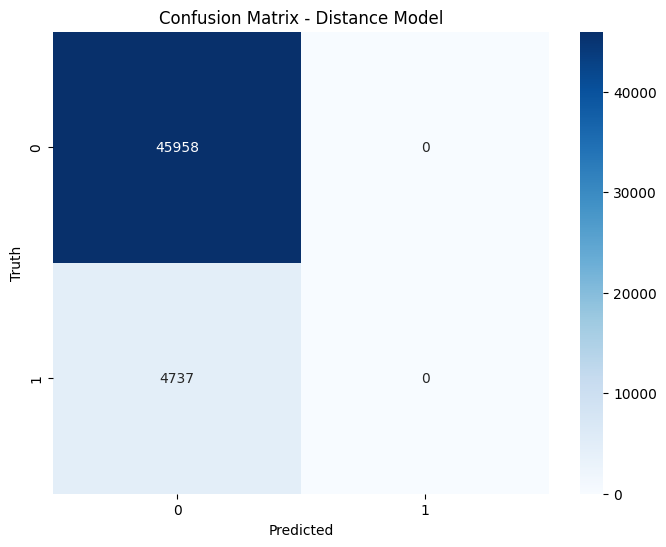

Distance Model Accuracy: 0.9065588322319755


In [20]:

# Confusion Matrix for Distance Model
cm_distance = confusion_matrix(y_val, y_pred_distance)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_distance, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - Distance Model')
plt.savefig('conf_matrix_distance.png')
plt.show()

# Calculate the model's score
score_distance = clf_distance.score(X_val[['shot_distance_to_goal']], y_val)
print(f'Distance Model Accuracy: {score_distance}')


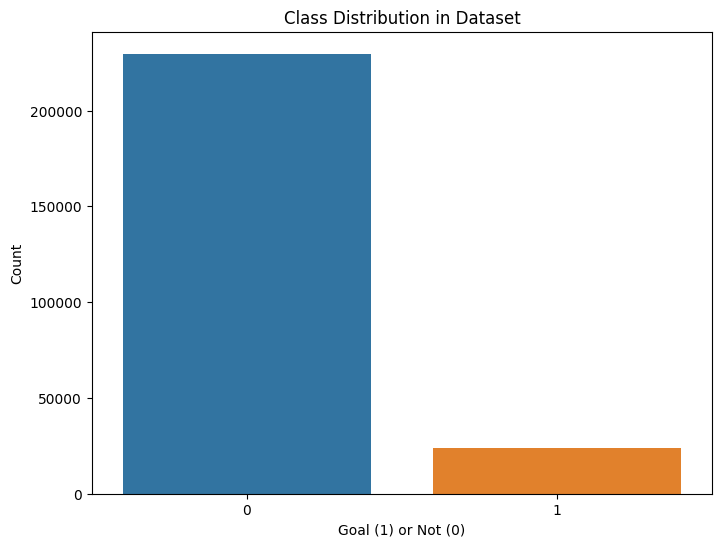

In [21]:
# Potential issue Imbalanced Classes
# Count the occurrences of each class (goal or not)
class_counts = y.value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Goal (1) or Not (0)')
plt.ylabel('Count')
plt.title('Class Distribution in Dataset')
plt.show()


Produce four figures (one curve per model per plot) to probe our model’s performance. Make sure you are using the probabilities obtained on the validation set:


In [75]:
def create_roc_curves(model_list, model_probs, valid_labels, file_name):
    plt.figure(figsize=(10, 6))
    line_width = 2
    for i, model in enumerate(model_list):
        false_positive_rate, true_positive_rate, _ = roc_curve(valid_labels.ravel(), model_probs[i].ravel())
        area_under_curve = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, lw=line_width, label=f"Model {model} - AUC: {area_under_curve:.2f}")

    plt.plot([0, 1], [0, 1], color="grey", lw=line_width, linestyle='--', label="Baseline (Random)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.savefig(file_name)
    plt.show()


In [76]:
def generate_goal_rate_plot(model_names, binned_data, output_file):
    plt.figure(figsize=(10, 5))
    plt.title("Analysis of Goal Rate by Model")
    for i, model in enumerate(model_names):
        sns.lineplot(x='goal_perc_bins', y='goal_rate', data=binned_data[i], linewidth=2.5, label=model)
    plt.xlabel('Model Probability Percentile')
    plt.ylabel('Goal Rate')
    plt.xticks(np.arange(0, 120, 20))
    plt.legend(loc="best")
    plt.savefig(output_file)
    plt.show()


In [77]:
def visualize_cumulative_goals(model_names, binned_data, file_path):
    plt.figure(figsize=(10, 5))
    plt.title("Cumulative Goals Analysis")
    for i, model in enumerate(model_names):
        sns.lineplot(x='goal_perc_bins', y='goal_cumsum', data=binned_data[i], linewidth=2.5, label=model)
    plt.xlabel('Percentile of Model Predictions')
    plt.ylabel('Cumulative Goal Ratio')
    plt.xticks(np.arange(0, 120, 20))
    plt.legend(loc="lower right")
    plt.savefig(file_path)
    plt.show()


In [78]:
def plot_model_calibration(model_names, probability_data, save_as):
    plt.figure(figsize=(7, 7))
    plt.title("Model Calibration Performance")
    plt.plot([0, 1], [0, 1], linestyle=':', color="black", label="Ideal Calibration")
    for i, model in enumerate(model_names):
        fraction_of_positives, mean_predicted_value = calibration_curve(probability_data[i]['goal'], probability_data[i]['goal_Prob'] / 100, n_bins=20)
        plt.plot(mean_predicted_value, fraction_of_positives, marker='s', label=f"{model}")
    plt.xlabel('Average Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.xticks(np.arange(0, 1.1, 0.2))
    plt.yticks(np.arange(0, 1.1, 0.2))
    plt.legend(loc="best")
    plt.savefig(save_as)
    plt.show()


In [79]:
# Model names
model_names = ['Distance', 'Angle', 'Both Features', 'Random Baseline']

# Predicted probabilities from each model
model_probs = [predicted_prob_distance, predicted_prob_angle, predicted_prob_both, y_prob_random]

# Predictions from each model
model_preds = [y_pred_distance, y_pred_angle, y_pred_both, y_pred_random]


In [80]:
def prepare_data_for_plots(y_pred, y_prob, y_val):
    df = pd.DataFrame({
        'goal_pred': y_pred,
        'goal': y_val,
        'goal_Prob': y_prob * 100  # Converting probabilities to percentages
    })
    df['shot'] = 1  # Counting each prediction as a shot
    sum_goal = df['goal'].sum()
    df['percentile'] = df['goal_Prob'].rank(pct=True) * 100
    df['goal_perc_bins'] = pd.cut(df['percentile'], bins=np.arange(0, 105, 5), labels=np.arange(2.5, 100, 5))
    return df

# Create DataFrames for each model
df_distance = prepare_data_for_plots(y_pred_distance, predicted_prob_distance, y_val)
df_angle = prepare_data_for_plots(y_pred_angle, predicted_prob_angle, y_val)
df_both = prepare_data_for_plots(y_pred_both, predicted_prob_both, y_val)
df_random = prepare_data_for_plots(y_pred_random, y_prob_random, y_val)

In [81]:
def bin_data(df):
    binned = df.groupby(['goal_perc_bins']).agg({'shot': 'sum', 'goal': 'sum'}).reset_index()
    binned['goal_rate'] = binned['goal'] / binned['shot']
    binned['goal_cum'] = binned['goal'].cumsum()
    binned['goal_cumsum'] = 1 - (binned['goal_cum'] / binned['goal'].sum())
    return binned

# Bin data for each model
df_binned_distance = bin_data(df_distance)
df_binned_angle = bin_data(df_angle)
df_binned_both = bin_data(df_both)
df_binned_random = bin_data(df_random)

In [83]:
df_prob_list = [df_distance, df_angle, df_both, df_random]
df_prob_bined_list = [df_binned_distance, df_binned_angle, df_binned_both, df_binned_random]
df_prob_list

[        goal_pred  goal  goal_Prob  shot  percentile goal_perc_bins
 27589           0     0  15.792813     1   78.774041           77.5
 224761          0     0   9.743142     1   58.743466           57.5
 32534           0     0   4.747657     1   29.431897           27.5
 157015          0     0  11.400828     1   65.111944           67.5
 202633          0     0   7.433930     1   47.856791           47.5
 ...           ...   ...        ...   ...         ...            ...
 215423          0     0  18.401422     1   89.886577           87.5
 89277           0     0   2.918430     1   12.142223           12.5
 82732           0     0  11.619872     1   65.708650           67.5
 72222           0     0  18.354412     1   89.272118           87.5
 176759          0     0   7.374479     1   47.437617           47.5
 
 [50695 rows x 6 columns],
         goal_pred  goal  goal_Prob  shot  percentile goal_perc_bins
 27589           0     0   9.396711     1   42.499260           42.5
 2247

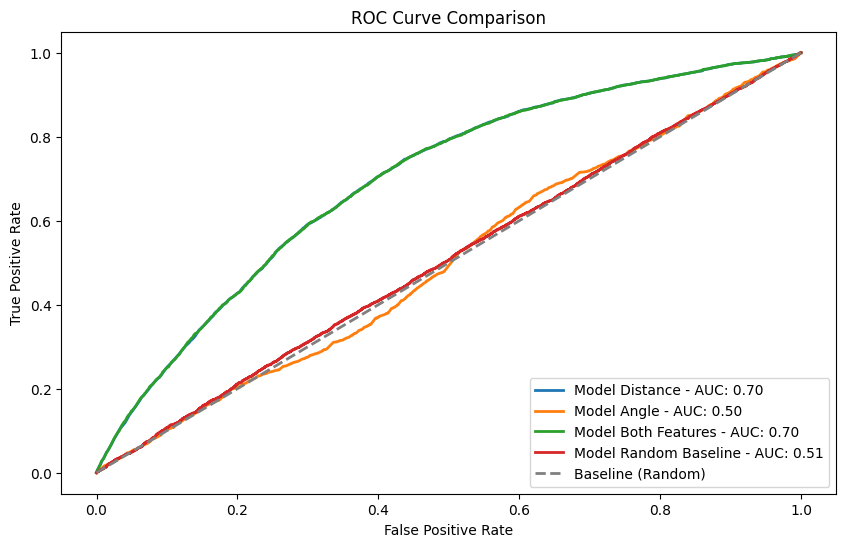

In [86]:
create_roc_curves(model_names, model_probs, y_val, 'roc_curve_plot.png')

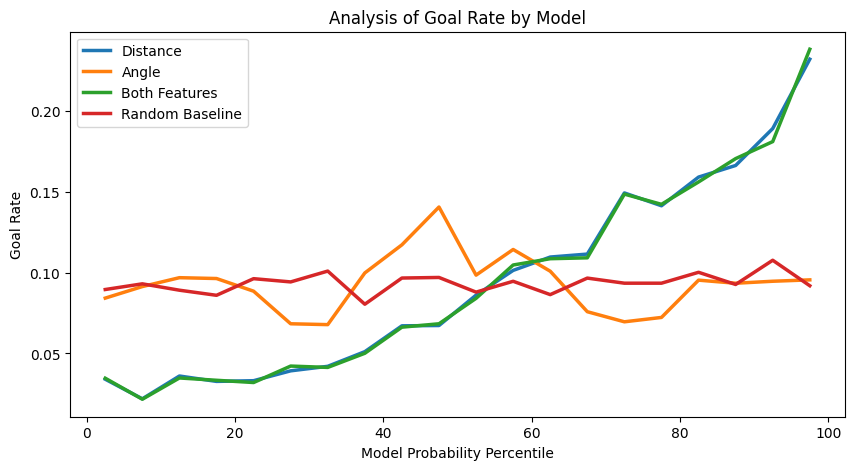

In [85]:
generate_goal_rate_plot(model_names, df_prob_bined_list, 'goal_rate_plot.png')

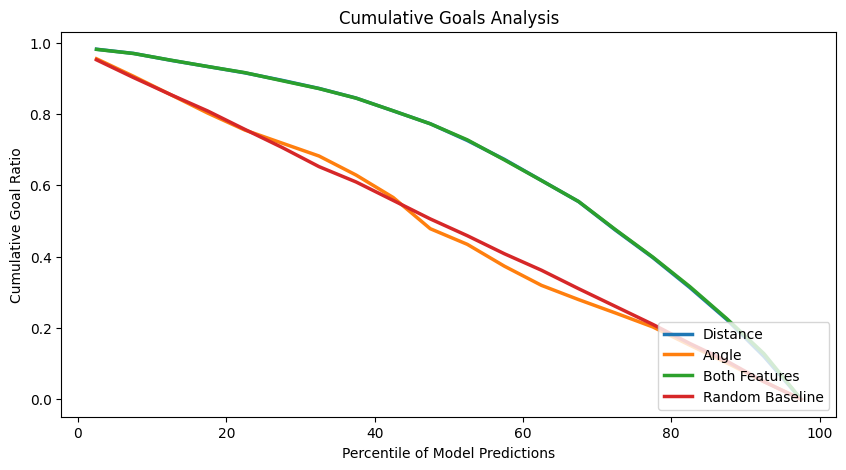

In [87]:
visualize_cumulative_goals(model_names, df_prob_bined_list, 'cumulative_goal_rate_plot.png')

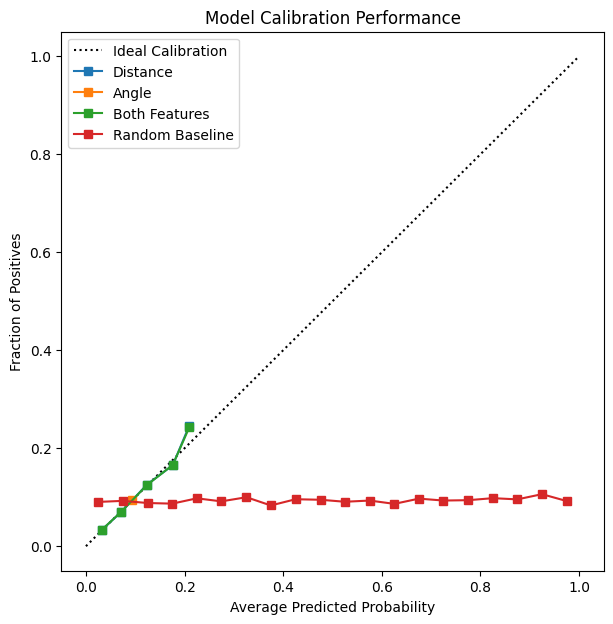

In [88]:
plot_model_calibration(model_names, df_prob_list, 'calibration_curve_plot.png')

In [94]:
# Log the ROC curve plot to Comet.ml
experiment.log_image('roc_curve_plot.png', name="ROC Curve", overwrite=False)

# Log the Goal Rate plot to Comet.ml
experiment.log_image('goal_rate_plot.png', name="Goal Rate", overwrite=False)

# Log the Cumulative Goal Rate plot to Comet.ml
experiment.log_image('cumulative_goal_rate_plot.png', name="Cumulative Goal Rate", overwrite=False)

# Log the Calibration Curve plot to Comet.ml
experiment.log_image('calibration_curve_plot.png', name="Calibration Curve", overwrite=False)


{'web': 'https://www.comet.com/api/image/download?imageId=3ae0f699d83f40c2ad6564f4aa7f9515&experimentKey=ed0b2e4869f4425eb4dbea530313c28f',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=3ae0f699d83f40c2ad6564f4aa7f9515&experimentKey=ed0b2e4869f4425eb4dbea530313c28f',
 'imageId': '3ae0f699d83f40c2ad6564f4aa7f9515'}